# Homework 2

**Studente**: Riccardo Armando Di Prinzio

**Matricola**: 261132

In [1]:
import time
from abc import ABC, abstractmethod
from copy import deepcopy
from enum import Enum
from typing import List, Tuple

import numpy as np
import pyCardDeck
from colorama import Fore, Style
from IPython.display import Image, clear_output
from pyCardDeck.cards import BaseCard

- Verranno ripresentati i componenti principali utilizzati per l'implementazione e la risoluzione del gioco **Crazy Eights** (tutti i seguenti componenti sono stati già utilizzati nell'**homework 1**):
    - Le **Classi astratte** necessarie all'implementazione.
    - La classe **Agent**.
    - L'**Infrastruttura** utilizzata per la simulazione.
    - L'**Algoritmo di ricerca** utilizzato per la risoluzione del gioco.


- Verrà successivamente presentato e risolto il seguente gioco ad **informazione imperfetta**:
    - **Crazy Eights**.

# Classi astratte

### Classe Representation
- la classe astratta `Representation` può essere utilizzata come template per definire la rappresentazione formale della realtà di un gioco.

- un'implementazione di questa classe astratta deve estendere la classe `Representation` ed implementare i seguenti metodi:
    - `is_endgame()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta la fine del gioco.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco, **False** altrimenti.
    - `print()`:
        - **descrizione**: metodo che si occupa della stampa a video della situazione di gioco corrente.
        - **parametri**: opzionali.
        - **ritorno**: nessun ritorno.

In [2]:
class Representation(ABC):
    @abstractmethod
    def is_endgame(self):
        return False

    @abstractmethod
    def print(self, **kwargs):
        pass

### Classe TurnBasedRepresentation
- la classe astratta `TurnBasedRepresentation` può essere utilizzata come template per definire la rappresentazione formale della realtà di un gioco a turni (due giocatori).

- la classe estende la classe astratta `Representation` ereditandone i metodi.

- un'implementazione di questa classe astratta deve estendere la classe `TurnBasedRepresentation` ed implementare, oltre i metodi della classe `Representation`, anche i seguenti metodi:
    - `is_victory()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, **False** altrimenti.
    - `is_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta la fine del gioco per pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per pareggio, **False** altrimenti.
    - `can_claim_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se la situazione di gioco corrente rappresenta una situazione in cui, a causa di varie sequenze di mosse ripetute, può essere chiesto un pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta una situazione in cui può essere chiesto il pareggio, **False** altrimenti.
    - `winner()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore vincente nel caso in cui la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se il giocatore 1 ha vinto, **False**, se il giocatore 2 ha vinto, **None**, se nessun giocatore ha vinto.
    - `winner_player()`:
        - **descrizione**: metodo che ritorna una stringa che identifica il giocatore vincente nel caso in cui la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `str`: stringa che identifica il giocatore vincente, **None**, se nessun giocatore ha vinto.
    - `outcome()`:
        - **descrizione**: metodo che ritorna un oggetto che identifica il risultato della partita nel caso in cui la situazione di gioco corrente rappresenta una situazione di fine gioco, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `object`: oggetto che identifica il risultato della partita, **None**, se la partita non è ancora conclusa.
    - `turn()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore che deve giocare.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se deve giocare il giocatore 1. **False**, se deve giocare il giocatore 2.

In [3]:
class TurnBasedRepresentation(Representation):
    @abstractmethod
    def is_victory(self):
        return False

    @abstractmethod
    def is_draw(self):
        return False

    @abstractmethod
    def can_claim_draw(self):
        return False

    @abstractmethod
    def winner(self):
        return None

    @abstractmethod
    def winner_player(self):
        return None

    @abstractmethod
    def outcome(self):
        return None

    @abstractmethod
    def turn(self):
        return True

### Classe State
- la classe astratta `State` può essere utilizzata come template per definire lo stato di un gioco. Viene creata per **contenere** la Rappresentazione di un gioco e definire attributi e metodi aggiuntivi necessari all'intelligenza artificiale per gestire le configurazioni in cui il gioco si può trovare.

- un'implementazione di questa classe astratta deve avere i seguenti attributi:
    - `h`: `float`: attributo in cui verrà salvato il valore euristico attribuito allo stato corrente dall'euristica. Inizialmente settato a **None**.
    - `g`: `float`: attributo in cui verrà eventualmente salvato il costo del path dallo stato iniziale allo stato corrente. Inizialmente settato a **None**.
    - `f`: `float`: attributo che conterrà la valutazione euristica finale dello stato corrente. Inizialmente settato a **None**.


- un'implementazione di questa classe astratta deve estendere `State` ed implementare i seguenti metodi:
    - `__init__(parent, representation)`:
        - **descrizione**: costruttore utilizzato per inizializzare lo stato del gioco.
        - **parametri**:
            - **parent**: `State`: stato padre dello stato corrente oppure **None** nel caso in cui lo stato non ha un parent.
            - **representation**: `Representation`: rappresentazione del gioco.
        - **ritorno**: nessun ritorno.
    - `is_endgame()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente è uno stato di fine gioco.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se lo stato corrente rappresenta uno stato di fine gioco, **False** altrimenti.
    - `print()`:
        - **descrizione**: metodo che si occupa della stampa a video dello stato corrente.
        - **parametri**: opzionali.
        - **ritorno**: nessun ritorno.

In [4]:
class State(ABC):
    @abstractmethod
    def __init__(self, parent, representation):
        pass

    @abstractmethod
    def is_endgame(self):
        return False

    @abstractmethod
    def print(self, **kwargs):
        pass

### Classe TurnBasedState
- la classe astratta `TurnBasedState` può essere utilizzata come template per definire lo stato di un gioco a turni (due giocatori). Viene creata per **contenere** la Rappresentazione di un gioco a turni e definire attributi e metodi aggiuntivi necessari all'intelligenza artificiale per gestire le configurazioni in cui il gioco si può trovare.


- la classe estende la classe astratta `State` ereditandone i metodi.


- un'implementazione di questa classe astratta deve avere i seguenti attributi:
    - `H`: `float`: attributo in cui verrà salvato il punteggio dello stato corrente. Inizialmente settato a **None**.
    - `move_H`: `float`: attributo in cui verrà salvato il punteggio euristico dell'ultima mossa effettuata nello stato corrente. Inizialmente settato a **None**.


- un'implementazione di questa classe astratta deve estendere la classe `TurnBasedState` ed implementare, oltre i metodi della classe `State`, anche i seguenti metodi:
    - `is_victory()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente rappresenta una situazione di fine del gioco per vittoria di un giocatore.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per vittoria di un giocatore, **False** altrimenti.
    - `is_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente rappresenta una situazione di fine del gioco per pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta la fine del gioco per pareggio, **False** altrimenti.
    - `can_claim_draw()`:
        - **descrizione**: metodo che ritorna un booleano che indica se lo stato corrente rappresenta una situazione di gioco in cui, a causa di varie sequenze di mosse ripetute, può essere chiesto un pareggio.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se la situazione di gioco corrente rappresenta una situazione in cui può essere chiesto il pareggio, **False** altrimenti.
    - `winner()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore vincente nel caso in cui lo stato corrente rappresenta la fine del gioco per vittoria di un giocatore, altrimenti ritorna None.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se il giocatore 1 ha vinto, **False**, se il giocatore 2 ha vinto, **None**, se nessun giocatore ha vinto.
    - `turn()`:
        - **descrizione**: metodo che ritorna un booleano che indica il giocatore che deve giocare.
        - **parametri**: nessun parametro.
        - **ritorno**: `bool`: **True**, se deve giocare il giocatore 1. **False**, se deve giocare il giocatore 2.

In [5]:
class TurnBasedState(State):
    @abstractmethod
    def is_victory(self):
        return False

    @abstractmethod
    def is_draw(self):
        return False

    @abstractmethod
    def can_claim_draw(self):
        return False

    @abstractmethod
    def winner(self):
        return None

    @abstractmethod
    def turn(self):
        return True

### Classe Game
- la classe astratta `Game` può essere utilizzata come template per definire la logica di generazione degli stati derivati dall'esecuzione delle mosse a partire da uno stato di partenza. La classe contiene il metodo `neighbors`, che si occupa della generazione degli stati che rappresentano le mosse legali che possono essere compiute a partire dallo stato passato come parametro.
- un'implementazione di questa classe astratta deve estendere `Game` ed implementare i seguenti metodi:
    - `neighbors(state)`:
        - **descrizione**: metodo che genera, dallo stato passato come parametro, tanti stati figli quanti sono le mosse legali possibili da esso.
        - **parametri**: `State`: stato da cui generare gli stati figli che rappresentano le mosse legali eseguite da esso.
        - **ritorno**: `list | set of states`: lista o set di stati figli generati dallo stato passato come parametro.

In [6]:
class Game(ABC):
    @abstractmethod
    def neighbors(self, state):
        return None

### Classe Heuristic
- la classe astratta `Heuristic` può essere utilizzata come template per definire le funzioni euristiche utilizzate dall'intelligenza artificiale. Il metodo da implementare prende in input uno stato del gioco e ritorna la sua valutazione euristica.
- un'implementazione di questa classe astratta deve estendere `Heuristic` ed implementare i seguenti metodi:
    - `H(state)`:
        - **descrizione**: metodo che valuta euristicamente lo stato **state** passato come parametro.
        - **parametri**:
            - **state**: `State`: stato su cui effettuare la valutazione euristica.
        - **ritorno**: `float | int`: valore che rappresenta il valore euristico attribuito allo stato.

In [7]:
class Heuristic(ABC):
    @abstractmethod
    def H(self, state):
        return 0.0

### Classe Algorithm
- la classe astratta `Algorithm` può essere utilizzata come template per definire gli algoritmi di ricerca nello spazio degli stati utilizzati dall'intelligenza artificiale.
- un'implementazione di questa classe astratta deve estendere `Algorithm` ed implementare i seguenti metodi:
    - `__init__(heuristic, game)`:
        - **descrizione**: costruttore utilizzato per inizializzare l'algoritmo di ricerca.
        - **parametri**:
            - **heuristic**: `Heuristic`: oggetto di classe Heuristic, che rappresenta l'euristica utilizzata dall'algoritmo per la valutazione degli stati.
            - **game**: `Game`: oggetto di classe Game, che contiene la logica di generazione degli stati che rappresentano le mosse del gioco su cui l'algoritmo viene applicato.
        - **ritorno**: nessun ritorno.
        
    - `pick(states)`:
        - **descrizione**: metodo che implementa la logica dell'algoritmo di ricerca con cui estrarre un nuovo stato dall'orizzonte corrente.
        - **parametri**:
            - **states**: `list | set of states`: orizzonte corrente degli stati.
        - **ritorno**: `State`: stato estratto dall'orizzonte degli stati secondo la sua valutazione euristica.
        
    - `evaluate(states)`:
        - **descrizione**: metodo che valuta euristicamente l'insieme di stati **states** passato come parametro ed assegna ad essi i punteggi euristici calcolati.
        - **parametri**:
            - **states**: `list | set of states`: insieme di stati su cui effettuare la valutazione euristica.
        - **ritorno**: nessun ritorno.
        
    - `search(state)`:
        - **descrizione**: metodo che esegue l'algoritmo di ricerca sullo stato passato come parametro. Vengono generati gli stati vicini a partire dallo stato `state` e viene estratto il prossimo stato che l'algoritmo considererà come migliore (secondo la valutazione euristica) tra gli stati presenti nell'orizzonte degli stati.
        - **parametri**:
            - **state**: `State`: stato su cui verrà eseguito l'algoritmo di ricerca.
        - **ritorno**: `State`: stato che l'algoritmo considera come migliore tra gli stati dell'orizzonte degli stati.

In [8]:
class Algorithm(ABC):
    @abstractmethod
    def __init__(self, heuristic, game):
        pass

    @abstractmethod
    def pick(self, states):
        return None

    @abstractmethod
    def evaluate(self, states):
        pass

    @abstractmethod
    def search(self, state):
        return None

# Classe Agent
- la classe `Agent` rappresenta l'agente che utilizzerà gli algoritmi di ricerca implementati per risolvere giochi che implementeranno le classi astratte specificate fino ad ora. L'agente è stato creato per essere generale e quindi per permettere all'utente utilizzatore di istanziare la classe agente per risolvere giochi differenti senza effettuare alcuna modifica su di essa.


- Di seguito verranno descritti gli **attributi** presenti nella classe `Agent`:
    - `search_algorithm`: `Algorithm`
        - **descrizione**: algoritmo di ricerca utilizzato dall'agente per decidere l'azione da intraprendere.
    - `new_view`: `State`
        - **descrizione**: stato in cui l'agente si trova dopo aver effettuato la decisione riguardo l'azione da intraprendere.
    - `old_view`: `State`
        - **descrizione**: stato in cui l'agente si trova prima di aver effettuato la decisione riguardo l'azione da intraprendere.
    - `action_times`: `list of float`
        - **descrizione**: lista che contiene i tempi di azione dell'agente. Essa sarà molto utile per effettuare statistiche sulle esecuzioni.


- Di seguito verranno descritti i **metodi** presenti nella classe `Agent`:
    - `__init__(search_algorithm, initial_state)`:
        - **descrizione**: costruttore utilizzato per inizializzare l'agente.
        - **parametri**:
            - **search_algorithm**: `Algorithm`: algoritmo di ricerca utilizzato per definire la logica di esplorazione dell'agente.
            - **initial_state**: `State`: stato di partenza dell'agente.
        - **ritorno**: nessun ritorno.
    - `do_action(world_state)`:
        - **descrizione**: metodo che prende come parametro lo stato corrente dell'ambiente e ritorna un nuovo stato che rappresenta lo stato dell'ambiente a seguito dell'applicazione dell'azione dell'agente. L'agente utilizza l'algoritmo di ricerca su cui è stato inizializzato per effettuare la decisione riguardo l'azione da intraprendere.
        - **parametri**:
            - **world_state**: `State`: stato che rappresenta la situazione corrente dell'ambiente.
        - **ritorno**: `State`: stato che rappresenta la situazione dell'ambiente a seguito dell'applicazione dell'azione dell'agente.
    - `get_average_action_time()`:
        - **descrizione**: metodo che effettua la media matematica sulla lista `action_times` che contiene i tempi di azione dell'agente.
        - **parametri**: nessun parametro.
        - **ritorno**: `float`: media matematica dei tempi di azione dell'agente.

In [9]:
class Agent:
    def __init__(self, search_algorithm, initial_state):
        self.search_algorithm = search_algorithm
        self.new_view = initial_state
        self.old_view = None
        # lista che contiene i tempi di azione dell'agente
        self.action_times = []

    def do_action(self, world_state):
        start = time.time()
        self.new_view = self.search_algorithm.search(world_state)
        end = time.time()
        self.action_times.append(end - start)
        self.old_view = world_state
        return self.new_view

    def get_average_action_time(self):
        n_samples = len(self.action_times)
        if n_samples == 0:
            return 0.0
        else:
            return sum(self.action_times) / n_samples

# Infrastruttura

## Infrastruttura a 2 agenti

- Definizione dell'infrastruttura che esegue la simulazione di una coppia di agenti che agiscono nel mondo

- `main_two_agents()`:
    - **descrizione**: funzione che esegue la simulazione di 2 agenti che agiscono sul mondo.
    - **parametri**:
        - **state**: `TurnBasedState`: parametro che specifica lo stato iniziale del mondo.
        - **agents**: `List[Tuple[Agent, str]]`: parametro che specifica gli agenti che agiscono sul mondo.
        - **clear_prints**: `bool`: parametro opzionale che specifica se mantenere soltanto la stampa più recente.
        - **\*\*kwargs**: parametri opzionali da passare alla funzione di stampa.

In [10]:
# funzione che esegue la simulazione di 2 agenti.
#
# state: TurnBasedState, parametro che specifica lo stato iniziale.
#
# agents: List[Tuple[Agent, str]], parametro che contiene i 2 agenti
# utilizzati nella simulazione nella forma: (agente, nome_agente).
#
# clear_prints: bool, parametro che specifica se mantenere
# soltanto la stampa più recente:
#  - True : mantiene solo la stampa più recente.
#  - False: conserva tutta la sequenza di stampe.
def main_two_agents(
    state: TurnBasedState, agents: List[Tuple[Agent, str]], clear_prints=False, **kwargs
):
    t = 0
    state.print(**kwargs)
    print()
    # fino a quando non ci sarà una situazione di fine gioco
    # gli agenti faranno azioni sul mondo.
    while not state.is_endgame():
        # gli agenti agiscono uno dopo l'altro a turno
        agent, agent_name = agents[t % 2]
        state = agent.do_action(state)
        t = t + 1
        if state is None:
            print("L'agente non è riuscito a risolvere il problema")
            return None
        if clear_prints:
            clear_output(wait=True)
        state.print(**kwargs)
        print(f"Mossa dell'agente: {agent_name}")
        print()

    # una volta raggiunto lo stato finale,
    # viene stampato il risultato
    print()
    print(f"Risultato: {state.representation.outcome()}")
    print(f"Vincitore: {state.representation.winner_player()}")

# Algoritmi di ricerca

## MinMax

- MinMax è un algoritmo di ricerca della mossa migliore in un gioco a somma zero che si svolge tra 2 giocatori (gioco a turni).

- L'algoritmo consente di individuare le scelte migliori dei due giocatori nel corso del gioco, analizzando a ritroso l'albero delle mosse a partire dai nodi terminali. Ad ogni passo, l'algoritmo assume che il giocatore A (giocatore max) cerchi di massimizzare le sue probabilità di vittoria, mentre il giocatore B (giocatore min) cerchi di minimizzare le probabilità di vittoria del giocatore A.

- Il giocatore max deve quindi massimizzare il valore del gioco mentre il giocatore min deve minimizzarlo.

- L'algoritmo MinMax consente quindi ai due giocatori di minimizzare le rispettive perdite, evitando quelle scelte che conducono ad una situazione peggiore o alla vittoria dell'altro giocatore.

- **Complessità**: L'algoritmo MinMax effettua una ricerca in profondità nell'albero di gioco, pertanto il numero di nodi da analizzare cresce in modo esponenziale con la profondità dell'albero. Al crescere dei nodi terminali, cresce la complessità spaziale e temporale dell'algoritmo. Per ridurre la complessità dell'algoritmo è possibile adottare delle tecniche di potatura dell'albero come ad esempio la Potatura Alpha-Beta (esse riducono il numero di ramificazioni e di nodi da analizzare nell'albero di ricerca).

In [11]:
class MinMax(Algorithm):
    def __init__(self, heuristic, game, max_depth):
        self.heuristic = heuristic
        self.game = game
        self.max_depth = max_depth
        self.prune_count = 0
        self.eval_count = 0

    # metodo che calcola i neighbors dello stato `state`
    # passato come parametro
    def __neighbors(self, state):
        return self.game.neighbors(state)

    # metodo che estrae e ritorna dal set di stati `states`:
    # - lo stato con massimo punteggio H se il turno corrente è
    # del giocatore max
    #
    # - lo stato con minimo punteggio H se il turno corrente è
    # del giocatore min
    def pick(self, states, parent_turn):
        if parent_turn:
            return max(states, key=lambda state: state.H)
        else:
            return min(states, key=lambda state: state.H)

    # metodo che esegue la valutazione degli
    # stati `states` nel turno `parent_turn`
    # secondo la logica di valutazione
    # dell'algoritmo MinMax
    def evaluate(self, states, parent_turn):
        for state in states:
            # controllo se può essere chiesto un pareggio (can_claim_draw)
            # a questo livello dato che tale controllo potrebbe
            # essere molto dispendioso in termini di performance:
            # dalle esecuzioni effettuate, questo controllo ha permesso
            # di evitare sequenze di mosse ripetute nel gioco degli Scacchi
            # portando ad un miglioramento della qualità di gioco
            # (questo controllo è stato testato sul gioco degli Scacchi, ma
            # potrebbe portare beneficio su qualsiasi altro gioco)
            if state.can_claim_draw():
                state.H = 0.0
            else:
                # se non viene chiesto un pareggio, proseguiamo normalmente
                # con la valutazione
                state.H = self.__minmax(state, self.max_depth - 1, not parent_turn)

    # implementazione della valutazione MinMax
    def __minmax(self, state, depth, turn):
        self.eval_count += 1

        if depth == 0 or state.is_endgame():
            return self.heuristic.H(state)

        if turn:
            value = -np.inf
            for child in self.__neighbors(state):
                value = max(value, self.__minmax(child, depth - 1, False))
            return value
        else:
            value = np.inf
            for child in self.__neighbors(state):
                value = min(value, self.__minmax(child, depth - 1, True))
            return value

    # metodo che esegue la ricerca del prossimo stato migliore
    # a partire dallo stato `state`
    def search(self, state: TurnBasedState):
        children = self.__neighbors(state)

        self.evaluate(children, state.turn())

        return self.pick(children, state.turn())

# Crazy Eights

## Descrizione del gioco

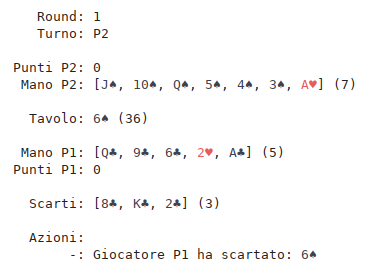

In [12]:
Image("img/crazy_eights_game.png")

- Crazy Eights è un gioco da 2 o più giocatori (nell'implementazione descritta, il gioco sarà di 2 giocatori: **P1** e **P2**), nel quale l'obiettivo di ogni giocatore è di svuotare la propria mano (avere 0 carte nella mano) per accumulare meno punteggio possibile durante i vari round che costituiscono la partita.

- L'immagine sopra descrive il turno di un giocatore:
    - **Round**: indica il round corrente.
    - **Turno**: indica il prossimo giocatore che deve giocare il turno.
    - **Punti P2**: indica i punti accumulati durante i vari round dal giocatore **P2**.
    - **Mano P2**: indica la mano del giocatore **P2**. Il numero tra parentesi indica la lunghezza della mano.
    - **Tavolo**: indica l'ultima carta giocata. Il numero tra parentesi indica il numero di carte rimaste nel mazzo.
    - **Mano P1**: indica la mano del giocatore **P1**. Il numero tra parentesi indica la lunghezza della mano.
    - **Punti P1**: indica i punti accumulati durante i vari round dal giocatore **P1**.
    - **Scarti**: insieme di carte giocate precedentemente. Indica le carte che sono state giocate sul tavolo nei turni precedenti. Se il mazzo viene rimescolato, gli scarti vengono azzerati. Il numero tra parentesi indica il numero di carte presenti negli scarti.
    - **Azioni**: Descrive le azioni compiute dal giocatore corrente durante il turno.


- Il round termina quando uno dei giocatori riesce a scartare tutte le carte che ha nella mano.

- Una volta terminato il round, si esegue il conteggio dei punti delle carte rimanenti nelle mani dei giocatori e si inizia un nuovo round (il giocatore che ha vinto il round accumulerà $0$ punti dato che non ha carte rimanenti).

- La partita termina quando uno dei giocatori accumula un punteggio totale $> 100$. In questo caso, il giocatore con minor punteggio vince la partita.

- Il gioco utilizza un mazzo di carte da Poker di 52 carte (non include i Jolly).

- Vengono distribuite 7 carte ad ogni giocatore e, una volta distribuite, viene pescata un'ulteriore carta e viene posta sul tavolo. Se la carta sul tavolo è un 8, essa viene reinserita a metà del mazzo e ne viene pescata un'altra.

- I giocatori possono giocare le carte che sono dello stesso rank (**2**, **3**, **A**, ...) della carta sul tavolo.

- I giocatori possono giocare le carte che sono dello stesso seme (♥, ♦, ♣, ♠) della carta sul tavolo.

- I giocatori possono sempre giocare un 8, in questo caso, il giocatore decide il prossimo seme che deve essere giocato.

- Se il giocatore corrente gioca un 2, obbliga il giocatore avversario a pescare 2 carte a meno che il giocatore non possa rispondere a sua volta con un 2. In questo caso l'effetto è cumulativo (le penalità si sommano e quindi il giocatore successivo dovrà pescare 4 carte).

- Se il giocatore corrente non può giocare alcuna carta, pesca carte dal mazzo fino a quando non può giocare una carta.

- Se, mentre il giocatore sta pescando le carte dal mazzo, il mazzo termina, il giocatore deve passare il turno all'avversario.

- I punteggi associati alle carte sono i seguenti:
    - **A** $\rightarrow$ 1
    - **2** $\rightarrow$ 2
    - **3** $\rightarrow$ 3
    - **4** $\rightarrow$ 4
    - **5** $\rightarrow$ 5
    - **6** $\rightarrow$ 6
    - **7** $\rightarrow$ 7
    - **8** $\rightarrow$ 50
    - **9** $\rightarrow$ 9
    - **10** $\rightarrow$ 10
    - **J** $\rightarrow$ 10
    - **Q** $\rightarrow$ 10
    - **K** $\rightarrow$ 10

## Implementazione

- Per quanto riguarda l'implementazione del mazzo di carte da Poker, si è deciso di utilizzare come supporto la **libreria esterna** [pyCardDeck](https://pypi.org/project/pyCardDeck/). Essa fornisce supporto alla gestione del mazzo di carte. Fornisce quindi l'oggetto Deck (oggetto che identifica il mazzo di carte) insieme a funzioni utili per pescare una carta dal mazzo, rimischiare il mazzo, gestire le carte scartate, e altro ancora. L'installazione di essa avviene mediante il comando: `pip install pyCardDeck==1.4.0`

- Per rendere multicolore la stampa delle carte del mazzo, si è deciso di utilizzare come supporto la **libreria esterna** [colorama](https://pypi.org/project/colorama/). Da essa sono state utilizzate alcune variabili che contengono sequenze di caratteri escape per produrre stampe multicolore su terminale. L'installazione di essa avviene mediante il comando: `pip install colorama==0.4.4`

- Per una ragione di efficienza nei calcoli, si è deciso di utilizzare come supporto la **libreria esterna** [numpy](https://numpy.org/doc/stable/). Da essa è stata utilizzata la variabile `np.inf`, che contiene una rappresentazione dell'infinito più efficiente da utilizzare rispetto alla versione built-in di Python. L'installazione di essa avviene mediante il comando: `pip install numpy==1.20.3`

### Creazione del mazzo di carte da Poker

- Il mazzo di carte da Poker utilizzato contiene 52 carte (i Jolly sono esclusi).

- Di seguito verranno presentati classi ed oggetti utili alla generazione del mazzo di carte da Poker.

In [13]:
# enumerazione che contiene i semi possibili
# delle carte
class Suit(Enum):
    HEARTS = 0
    DIAMONDS = 1
    CLUBS = 2
    SPADES = 3


# enumerazione che contiene i possibili
# rank delle carte
class Rank(Enum):
    ACE = "A"
    TWO = "2"
    THREE = "3"
    FOUR = "4"
    FIVE = "5"
    SIX = "6"
    SEVEN = "7"
    EIGHT = "8"
    NINE = "9"
    TEN = "10"
    JACK = "J"
    QUEEN = "Q"
    KING = "K"


# colori associati ai semi (rosso e nero)
colors = [Fore.RED, Fore.RED, Fore.BLACK, Fore.BLACK]

# dizionario che contiene l'associazione
# seme - carattere che lo rappresenta
suits = {Suit.HEARTS: "♥", Suit.DIAMONDS: "♦", Suit.CLUBS: "♣", Suit.SPADES: "♠"}

# dizionario che contiene l'associazione
# rank - valore di ciascuna carta
ranks_values = {
    Rank.ACE: 1,
    Rank.TWO: 2,
    Rank.THREE: 3,
    Rank.FOUR: 4,
    Rank.FIVE: 5,
    Rank.SIX: 6,
    Rank.SEVEN: 7,
    Rank.EIGHT: 50,
    Rank.NINE: 9,
    Rank.TEN: 10,
    Rank.JACK: 10,
    Rank.QUEEN: 10,
    Rank.KING: 10,
}

In [14]:
# classe che rappresenta una singola carta
# da Poker
class PokerCard(BaseCard):
    def __init__(self, rank, suit):
        # rank della carta
        self.rank = rank
        # valore della carta
        self.value = ranks_values[self.rank]
        # seme della carta
        self.suit = suit
        # rappresentazione in stringa della carta
        self.name = f"{colors[self.suit.value]}{self.rank.value}{suits[self.suit]}{Style.RESET_ALL}"

    def __str__(self):
        return self.name

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        if not isinstance(other, PokerCard):
            return False
        else:
            return self.name == other.name

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash(self.name)

    def __lt__(self, other):
        return self.value < other.value

In [15]:
# classe utilizzata per generare un mazzo
# legale di carte da poker per Crazy Eights
class CardDecks:
    # metodo che genera il mazzo di carte da Poker
    @staticmethod
    def generate_poker_deck(deck_name, graveyard=None):
        return pyCardDeck.Deck(
            cards=CardDecks.__poker_deck_cards(),
            name=deck_name,
            reshuffle=False,
            discard=graveyard,
        )

    # metodo che genera la pila degli scarti
    @staticmethod
    def generate_deck_graveyard(deck_name):
        return pyCardDeck.Deck(cards=[], name=deck_name, reshuffle=False)

    # metodo che crea l'array di carte
    @staticmethod
    def __poker_deck_cards():
        cards = []
        for suit, _ in suits.items():
            for rank, _ in ranks_values.items():
                cards.append(PokerCard(rank, suit))
        return cards

In [16]:
# test di generazione di un mazzo di carte da Poker
test_deck = CardDecks.generate_poker_deck("test")
test_deck.shuffle()
test_deck.show_top(5)

[A♦, K♦, K♠, K♥, 4♦]

- Di seguito verranno presentate le classi che costituiscono il gioco **Crazy Eights**. L'implementazione utilizza le classi astratte definite nell'homework 1.

- Verranno quindi utilizzate le classi **TurnBasedRepresentation**, **TurnBasedState** e **Game** per codificare il gioco.

### Rappresentazione

In [17]:
class CrazyEightsRepr(TurnBasedRepresentation):
    def __init__(self):
        self.graveyard = CardDecks.generate_deck_graveyard(
            deck_name="CrazyEights graveyard"
        )
        self.deck = CardDecks.generate_poker_deck(
            deck_name="CrazyEights deck", graveyard=self.graveyard
        )
        self.table_card = None
        self.round = 1
        self.round_ended = False
        self.deal_to = False
        self.last_turn = None
        self.player_turn = True
        self.points = [0, 0]
        self.hands = [[], []]
        self.max_points = 100
        self.crazy_suit = None
        self.actions = []
        self.cards_to_draw = 1

        # inizializzazione partita
        self.__init()

    # metodo che inizializza la partita:
    # consegna le carte ai giocatori
    def __init(self):
        self.deal_cards()

    # metodo che controlla se la carta identificata
    # dal parametro `card` è scartabile
    def is_throwable(self, card):
        if self.crazy_suit is None:
            return (
                card.rank == self.table_card.rank
                or card.suit == self.table_card.suit
                or card.rank == Rank.EIGHT
            )
        else:
            return card.suit == self.crazy_suit or card.rank == Rank.EIGHT

    # metodo che ritorna la lista di carte scartabili
    # del giocatore corrente
    def get_throwable_cards(self):
        throwables = [
            card for card in self.get_current_player_hand() if self.is_throwable(card)
        ]
        return throwables

    # metodo che permette al giocatore corrente di scartare
    # la carta `card`.
    #
    # Nel caso in cui la carta è un 8, il parametro
    # `crazy_suit_choice` identifica il seme scelto
    def throw_card(self, card, crazy_suit_choice=None):
        if self.is_throwable(card):
            # è possibile scartare la carta
            self.graveyard.add_single(self.table_card, 0)
            self.table_card = card
            self.get_current_player_hand().remove(card)
            self.actions.append(f"Giocatore {self.turn_str()} ha scartato: {card}")

            if self.cards_to_draw != 1 and card.rank != Rank.TWO:
                raise RuntimeError("Il Giocatore deve pescare le carte o scartare un 2")

            if card.rank == Rank.EIGHT:
                # la carta è un 8, scelta di un seme richiesta
                if crazy_suit_choice is not None:
                    self.crazy_suit = crazy_suit_choice
                    self.actions.append(f"Seme scelto: {crazy_suit_choice}")
                else:
                    raise RuntimeError("Seme scelto mancante")

            elif card.rank == Rank.TWO:
                # la carta è un 2, il prossimo giocatore deve pescare 2 carte
                if self.cards_to_draw == 1:
                    self.cards_to_draw = 2
                else:
                    # l'effetto è cumulativo
                    self.cards_to_draw += 2

            else:
                # altre carte
                self.crazy_suit = None

            # la carta scelta è stata scartata, se il round è concluso,
            # aggiorna i punteggi
            if self.is_end_round():
                self.round_ended = True
                self.update_points()

            # infine, esegui lo swap del turno
            self.swap_turn()

        else:
            # non è possibile scartare la carta
            raise RuntimeError("Carta non valida")

    # metodo utilizzato per distribuire le carte
    # ai giocatori
    def deal_cards(self):
        self.deck.shuffle_back()
        # consegna le carte ai giocatori
        for _ in range(14):
            self.__deal_card_to_player(self.deal_to)
            self.deal_to = not self.deal_to
        # aggiungi la carta sul tavolo
        card = self.draw()
        # se la carta è un 8, mettila in mezzo al mazzo e ripesca
        while card.rank == Rank.EIGHT:
            self.deck.add_single(card, self.deck.cards_left // 2)
            card = self.draw()
        self.table_card = card

    # metodo che esegue un reset del round.
    # Viene utilizzato per poter effettuare
    # il cambio del round
    def clear_round(self):
        self.graveyard.add_many(self.hands[0])
        self.graveyard.add_many(self.hands[1])
        self.graveyard.add_single(self.table_card, 0)
        self.hands[0].clear()
        self.hands[1].clear()
        self.table_card = None
        self.deck.shuffle_back()

    # metodo che permette di giocare un nuovo round
    def new_round(self):
        self.round += 1
        self.round_ended = False
        self.cards_to_draw = 1
        self.deal_cards()

    # metodo che esegue l'aggiornamento dei punteggi
    # dei giocatori
    def update_points(self):
        self.points[0] += sum([card.value for card in self.hands[0]])
        self.points[1] += sum([card.value for card in self.hands[1]])

    # metodo che distribuisce le carte al giocatore
    # `player`
    def __deal_card_to_player(self, player):
        player_hand = self.hands[int(player)]
        card = self.draw()
        self.actions.append(
            f"Carta {card} consegnata al giocatore {'P1' if player else 'P2'}"
        )
        player_hand.append(card)

    # metodo che permette al giocatore corrente di pescare
    # le carte dal mazzo
    def player_draw(self):
        to_draw = self.cards_to_draw
        player_hand = self.get_current_player_hand()
        for _ in range(0, to_draw):
            card = self.draw()
            self.actions.append(
                f"Il giocatore {self.turn_str()} ha pescato la carta {card}"
            )
            player_hand.append(card)
            if self.deck.empty:
                self.swap_turn()
                self.cards_to_draw = 1
                return
        self.cards_to_draw = 1

    # metodo che pesca una carta dal mazzo
    def draw(self):
        if self.deck.empty:
            self.deck.shuffle_back()
        return self.deck.draw()

    # metodo che ritorna la mano del giocatore corrente
    def get_current_player_hand(self):
        return self.hands[int(self.player_turn)]

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di fine round
    def is_end_round(self):
        return (len(self.hands[0]) == 0) or (len(self.hands[1]) == 0)

    # metodo che permette al giocatore corrente
    # di passare il turno
    def swap_turn(self):
        self.last_turn = self.player_turn
        self.player_turn = not self.last_turn

    # metodo che ritorna una stringa che identifica
    # il giocatore che deve giocare
    def turn_str(self):
        return "P1" if self.player_turn else "P2"

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di partita terminata
    # (fine gioco)
    def is_endgame(self):
        return (self.points[0] > self.max_points) or (self.points[1] > self.max_points)

    # metodo che stampa a video la rappresentazione corrente
    def print(self, **kwargs):
        print()
        print()
        print(f"   Round: {self.round}")
        print(f"   Turno: {self.turn_str()}")
        print()
        print(f"Punti P2: {self.points[0]}")
        print(f" Mano P2: {sorted(self.hands[0], reverse=True)} ({len(self.hands[0])})")
        print()
        print(f"  Tavolo: {self.table_card} ({len(self.deck._cards)})")
        print()
        print(f" Mano P1: {sorted(self.hands[1], reverse=True)} ({len(self.hands[1])})")
        print(f"Punti P1: {self.points[1]}")
        print()
        print(f"  Scarti: {self.graveyard._cards} ({len(self.graveyard._cards)})")
        print()
        print("  Azioni:")

        for action in self.actions:
            print(f"       -: {action}")

        print()

    # metodo che ritorna un booleano che indica se
    # la rappresentazione corrente corrisponde
    # ad una situazione di fine gioco
    def is_victory(self):
        return self.is_endgame()

    # in questo gioco non abbiamo
    # situazioni di pareggio
    def is_draw(self):
        return False

    # in questo gioco non abbiamo
    # situazioni in cui può essere
    # chiesto un pareggio
    def can_claim_draw(self):
        return False

    # metodo che restituisce un booleano che
    # corrisponde al giocatore vincente
    # ({P1, P2}) se la rappresentazione
    # corrente corrisponde ad una situazione
    # di fine gioco. Altrimenti restituisce None.
    # Return:
    #     True : se il giocatore vincente è P1
    #     False: se il giocatore vincente è P2
    #     None : altrimenti
    def winner(self):
        if self.is_victory():
            min_player = bool(self.points.index(min(self.points)))
            return min_player
        return None

    # metodo che ritorna il giocatore vincente
    # ({P1, P2}) se la rappresentazione
    # corrente corrisponde ad una situazione
    # di fine gioco.
    # Altrimenti viene restituito None
    def winner_player(self):
        if self.is_victory():
            return "P1" if self.winner() else "P2"
        return None

    # metodo che restituisce un oggetto che indica
    # il risultato dalla partita nel caso in
    # cui la rappresentazione corrente corrisponde ad una
    # situazione di fine gioco. Altrimenti viene
    # restituito None
    def outcome(self):
        if self.is_victory():
            return f"Vittoria per il giocatore '{self.winner_player()}'"
        return None

    # metodo che restituisce un booleano che indica
    # il giocatore che deve giocare:
    #   True : il giocatore `P1` deve giocare
    #   False: il giocatore `P2` deve giocare
    def turn(self):
        return self.player_turn

### Stato

In [18]:
class CrazyEightsState(TurnBasedState):
    def __init__(self, parent=None, representation=None):
        if representation is None:
            self.representation = CrazyEightsRepr()
        else:
            self.representation = representation

        self.parent = parent
        self.H = None
        self.move_H = None

    # metodo che ritorna un booleano che indica se
    # lo stato corrente corrisponde
    # ad uno stato di fine gioco
    def is_endgame(self):
        return self.representation.is_endgame()

    # metodo che stampa a video lo stato corrente
    def print(self, **kwargs):
        self.representation.print(**kwargs)

    # metodo che ritorna un booleano che indica se
    # lo stato corrente corrisponde
    # ad uno stato di fine gioco
    def is_victory(self):
        return self.representation.is_victory()

    # in questo gioco non abbiamo
    # situazioni di pareggio
    # return: viene restituito sempre False
    def is_draw(self):
        return self.representation.is_draw()

    # in questo gioco non abbiamo
    # situazioni in cui può essere
    # chiesto un pareggio
    # return: viene restituito sempre False
    def can_claim_draw(self):
        return self.representation.can_claim_draw()

    # metodo che restituisce un booleano che
    # corrisponde al giocatore vincente
    # ({P1, P2}) se lo stato
    # corrente corrisponde ad una situazione
    # di fine gioco. Altrimenti restituisce None.
    # Return:
    #     True : se il giocatore vincente è P1
    #     False: se il giocatore vincente è P2
    #     None : altrimenti
    def winner(self):
        return self.representation.winner()

    # metodo che restituisce un booleano che indica
    # il giocatore che deve giocare:
    #   True : il giocatore `P1` deve giocare
    #   False: il giocatore `P2` deve giocare
    def turn(self):
        return self.representation.turn()

### Gioco

In [19]:
class CrazyEightsGame(Game):
    # metodo che ritorna un set di stati che corrispondono alle mosse
    # legali che è possibile eseguire a partire dallo stato `state`
    # passato come parametro
    def neighbors(self, state):
        current_repr = state.representation
        current_turn = state.representation.turn()

        if current_repr.round_ended and not current_repr.is_endgame():
            # situazione di fine round: ri-consegnare le carte
            new_move = deepcopy(current_repr)
            new_move.actions = []
            new_move.clear_round()
            new_move.new_round()
            # swap del turno
            new_move.swap_turn()

            return [CrazyEightsState(parent=state, representation=new_move)]

        elif not current_repr.is_endgame():
            # round standard: il giocatore corrente esegue la sua mossa
            moves = []
            current_situation = deepcopy(current_repr)
            current_situation.actions = []

            # carte che possono essere giocate
            throwables = current_situation.get_throwable_cards()

            if current_situation.cards_to_draw != 1:
                # il giocatore deve pescare cards_to_draw carte oppure scartare
                # un altro 2
                if any(card.rank == Rank.TWO for card in throwables):
                    # il giocatore ha un 2, lo scarta
                    for two_card in [
                        card for card in throwables if card.rank == Rank.TWO
                    ]:
                        new_move = deepcopy(current_situation)
                        new_move.throw_card(two_card)
                        moves.append(
                            CrazyEightsState(parent=state, representation=new_move)
                        )
                    return moves
                else:
                    # il giocatore deve pescare le carte e passare il turno
                    current_situation.player_draw()
                    if current_turn != current_situation.turn():
                        # il turno è cambiato, il mazzo è vuoto
                        # il giocatore deve passare il turno
                        return [
                            CrazyEightsState(
                                parent=state, representation=current_situation
                            )
                        ]
                    # il giocatore ha pescato le carte, deve passare il turno
                    current_situation.swap_turn()
                    return [
                        CrazyEightsState(parent=state, representation=current_situation)
                    ]

            # situazione di gioco normale: se il giocatore non può giocare
            # carte, deve pescare fino a quando non ha una carta giocabile
            while len(throwables) == 0:
                # il giocatore non ha carte giocabili, deve pescare
                current_situation.player_draw()
                if current_turn != current_situation.turn():
                    # il turno è cambiato, il mazzo è vuoto
                    # il giocatore deve passare il turno
                    return [
                        CrazyEightsState(parent=state, representation=current_situation)
                    ]
                throwables = current_situation.get_throwable_cards()

            # il giocatore ha carte giocabili, può scartare una carta
            crazy_moves = []
            for card in throwables:
                new_move = deepcopy(current_situation)

                if card.rank == Rank.EIGHT:
                    # il giocatore scarta un 8, deve scegliere un seme
                    for suit in list(Suit):
                        crazy_move = deepcopy(new_move)
                        crazy_move.throw_card(card, crazy_suit_choice=suit)
                        crazy_moves.append(
                            CrazyEightsState(parent=state, representation=crazy_move)
                        )
                    continue
                else:
                    # altra carta
                    new_move.throw_card(card)

                moves.append(CrazyEightsState(parent=state, representation=new_move))

            return moves + crazy_moves

        else:
            # situazione di fine gioco, nessun nuovo stato a partire da esso
            return []

### Euristiche

- Vengono di seguito presentate le **diverse euristiche** utilizzate per Crazy Eights:
    - **h1(n): lunghezza della mano del giocatore corrente**: funzione euristica che calcola la lunghezza della mano del giocatore corrente (il numero di carte che il giocatore corrente ha nella mano). Il giocatore corrente vuole minimizzare questo valore.

    - **h2(n): valore della mano del giocatore corrente**: funzione euristica che calcola il punteggio della mano del giocatore corrente (la somma dei punteggi delle carte che il giocatore corrente ha nella mano). Il giocatore corrente vuole minimizzare questo valore.

    - **h3(n): probabilità dell'avversario di avere carte giocabili**: funzione euristica che calcola la probabilità che il giocatore avversario possa avere carte giocabili. Il giocatore corrente vuole minimizzare questa probabilità.

    - **H(n): valutazione combinata**: funzione euristica derivata dalla combinazione di **h1**, **h2**, **h3**. L'euristica attribuisce un punteggio allo stato in base alla combinazione tra la lunghezza e il punteggio della mano del giocatore corrente insieme alla probabilità dell'avversario di avere carte giocabili:
    $$ H = h_3 \cdot (h_1 + h_2) $$


- Per l'implementazione delle euristiche, verrà utilizzata la classe astratta **Heuristic** definita nell'homework 1.

In [20]:
# Classe che contiene alcune euristiche
# che attribuiscono un punteggio allo stato
# in base alla situazione della partita
class CrazyEightsHeuristic(Heuristic):
    # h1(n): hand length heuristic
    # funzione euristica per Crazy Eights che attribuisce
    # un punteggio agli stati in base alla lunghezza della mano
    # del giocatore corrente
    def __current_player_hand_length_heuristic(self, state):
        # turno del giocatore corrente
        turn = not state.turn()
        # calcolo lunghezza mano
        hand_length = len(state.representation.hands[int(turn)])
        return -hand_length if turn else hand_length

    # h2(n): hand points heuristic
    # funzione euristica per Crazy Eights che attribuisce
    # un punteggio agli stati in base al punteggio della mano
    # del giocatore corrente
    def __current_player_hand_points_heuristic(self, state):
        # turno del giocatore corrente
        turn = not state.turn()
        # calcolo punteggio mano
        hand_points = sum(
            [card.value for card in state.representation.hands[int(turn)]]
        )
        return -hand_points if turn else hand_points

    # h3(n): opponent response probability heuristic
    # funzione euristica per Crazy Eights che ritorna la
    # probabilità che l'avversario possa avere carte giocabili
    def __opponent_player_response_probability_heuristic(self, state):
        # turno dell'avversario
        enemy_turn = state.turn()
        # le carte che non sono ancora uscite sono quelle
        # che sono nella mano dell'avversario e quelle che
        # sono ancora nel mazzo di carte
        hidden_cards = (
            state.representation.hands[int(enemy_turn)]
            + state.representation.deck._cards
        )

        # l'avversario potrebbe avere qualsiasi carta tra quelle
        # che non sono ancora uscite (non possiamo sapere cosa
        # l'avversario ha nella mano), contiamo quindi il
        # numero di carte giocabili tra le carte che
        # non ancora sono uscite
        throwable_cards = 0
        for card in hidden_cards:
            if state.representation.is_throwable(card):
                throwable_cards += 1

        # la probabilità che l'avversario abbia carte giocabili
        # è quindi:
        # numero di carte giocabili rimaste / numero totale di carte rimaste
        return throwable_cards / len(hidden_cards)

    # H(n): evaluation heuristic
    # funzione euristica per Crazy Eights che attribuisce
    # un punteggio agli stati combinando le euristiche
    # precedentemente definite.
    #
    # Nel caso in cui lo stato valutato non è uno stato di gioco terminato
    # per vittoria di un giocatore, allora il punteggio attributo allo stato
    # valutato viene dato dalla combinazione:
    # h3 * (h1 + h2)
    def H(self, state):
        if state.is_victory():
            return np.inf if state.winner() else -np.inf
        else:
            opponent_player_response_prob = (
                self.__opponent_player_response_probability_heuristic(state)
            )
            current_player_hand_len = self.__current_player_hand_length_heuristic(state)
            current_player_hand_points = self.__current_player_hand_points_heuristic(
                state
            )

            return opponent_player_response_prob * (
                current_player_hand_len + current_player_hand_points
            )

### Algoritmi di ricerca applicabili

- MinMax\*

\*: applicabile a profondità massima 1.

In [21]:
max_depth = 1

- Verrà utilizzato l'algoritmo di ricerca **MinMax** definito nell'homework 1 applicato a profondità massima 1.

## Esecuzione

- Utilizzo infrastruttura a due agenti.

- Verrà utilizzata l'**infrastruttura a 2 agenti** definita nell'homework 1.

In [22]:
# inizializzazione gioco ed euristica
crazy_eights_heuristic = CrazyEightsHeuristic()
game = CrazyEightsGame()

# stato iniziale
initial_state = CrazyEightsState()

print("Stato iniziale")
initial_state.print()

Stato iniziale


   Round: 1
   Turno: P1

Punti P2: 0
 Mano P2: [8♦, Q♦, K♥, 9♥, 9♠, 2♣, A♥] (7)

  Tavolo: 5♣ (37)

 Mano P1: [K♣, K♦, 10♦, 10♠, 6♠, 4♠, 3♠] (7)
Punti P1: 0

  Scarti: [] (0)

  Azioni:
       -: Carta 9♥ consegnata al giocatore P2
       -: Carta K♣ consegnata al giocatore P1
       -: Carta 8♦ consegnata al giocatore P2
       -: Carta 6♠ consegnata al giocatore P1
       -: Carta Q♦ consegnata al giocatore P2
       -: Carta 3♠ consegnata al giocatore P1
       -: Carta K♥ consegnata al giocatore P2
       -: Carta K♦ consegnata al giocatore P1
       -: Carta 9♠ consegnata al giocatore P2
       -: Carta 10♦ consegnata al giocatore P1
       -: Carta A♥ consegnata al giocatore P2
       -: Carta 4♠ consegnata al giocatore P1
       -: Carta 2♣ consegnata al giocatore P2
       -: Carta 10♠ consegnata al giocatore P1



In [23]:
# inizializzazione agenti
agent_1 = Agent(
    MinMax(
        heuristic=crazy_eights_heuristic,
        game=game,
        max_depth=max_depth,
    ),
    initial_state,
)
agent_2 = Agent(
    MinMax(
        heuristic=crazy_eights_heuristic,
        game=game,
        max_depth=max_depth,
    ),
    initial_state,
)
agents = [(agent_1, "Agent 1 (P1)"), (agent_2, "Agent 2 (P2)")]

# inizio simulazione
main_two_agents(initial_state, agents)



   Round: 1
   Turno: P1

Punti P2: 0
 Mano P2: [8♦, Q♦, K♥, 9♥, 9♠, 2♣, A♥] (7)

  Tavolo: 5♣ (37)

 Mano P1: [K♣, K♦, 10♦, 10♠, 6♠, 4♠, 3♠] (7)
Punti P1: 0

  Scarti: [] (0)

  Azioni:
       -: Carta 9♥ consegnata al giocatore P2
       -: Carta K♣ consegnata al giocatore P1
       -: Carta 8♦ consegnata al giocatore P2
       -: Carta 6♠ consegnata al giocatore P1
       -: Carta Q♦ consegnata al giocatore P2
       -: Carta 3♠ consegnata al giocatore P1
       -: Carta K♥ consegnata al giocatore P2
       -: Carta K♦ consegnata al giocatore P1
       -: Carta 9♠ consegnata al giocatore P2
       -: Carta 10♦ consegnata al giocatore P1
       -: Carta A♥ consegnata al giocatore P2
       -: Carta 4♠ consegnata al giocatore P1
       -: Carta 2♣ consegnata al giocatore P2
       -: Carta 10♠ consegnata al giocatore P1




   Round: 1
   Turno: P2

Punti P2: 0
 Mano P2: [8♦, Q♦, K♥, 9♥, 9♠, 2♣, A♥] (7)

  Tavolo: K♣ (37)

 Mano P1: [K♦, 10♦, 10♠, 6♠, 4♠, 3♠] (6)
Punti P1: 0

  Scar

In [25]:
print(f"Stati valutati        (agente 1): {agent_1.search_algorithm.eval_count}")
print(f"Tempo di azione medio (agente 1): {agent_1.get_average_action_time()}")
print()
print(f"Stati valutati        (agente 2): {agent_2.search_algorithm.eval_count}")
print(f"Tempo di azione medio (agente 2): {agent_2.get_average_action_time()}")

Stati valutati        (agente 1): 583
Tempo di azione medio (agente 1): 0.0048851725288424725

Stati valutati        (agente 2): 505
Tempo di azione medio (agente 2): 0.0053402684333566
